In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

### Load session and complete climb data

In [43]:
sessions = pd.read_csv('raw_data/5513-climb-session-export-2024-02-17T22-15-04.csv')
climbs = pd.read_csv('raw_data/5513-climb-export-2024-02-17T22-15-04.csv')

In [44]:
climbs.head()

,Session ID,Time,Discipline,Level,Attempt,Grade System
0,7.297506e+08,2024-02-15 20:31:59,Boulder,V0,False,hueco
1,7.297506e+08,2024-02-15 20:32:54,Boulder,V0,False,hueco
2,7.297506e+08,2024-02-15 20:32:56,Boulder,V1,False,hueco
3,7.297506e+08,2024-02-15 20:34:11,Boulder,V2,False,hueco
4,7.297506e+08,2024-02-15 20:35:21,Boulder,V1,False,hueco


### Progress per bouldering grade

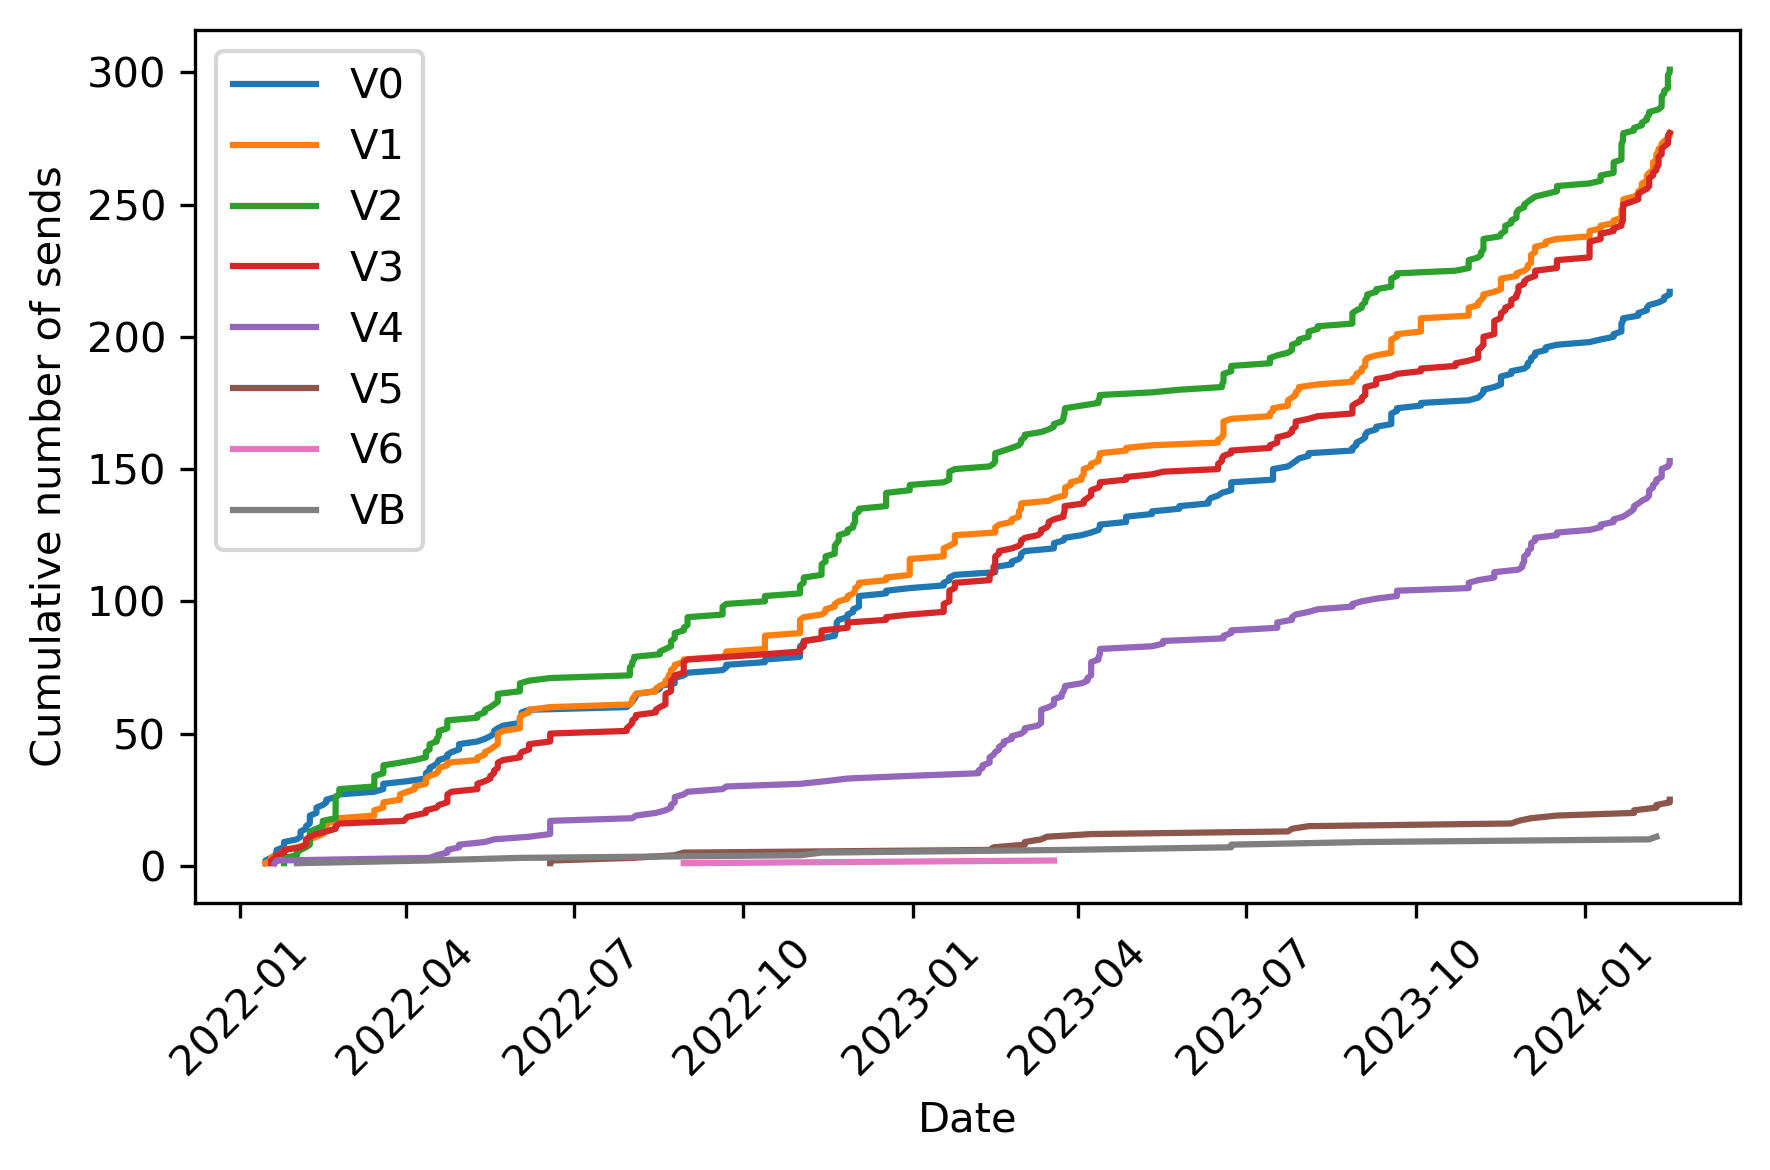

In [45]:
# subset bouldering data only 
boulders = climbs[climbs['Discipline'] == 'Boulder']

grouped_levels = {}
for level, group in boulders.groupby('Level'):
    grouped_levels[level] = group

sends = {}
for level, group_df in grouped_levels.items():
    sends[level] = group_df[group_df['Attempt'] == False]

plt.figure(figsize=(6, 4),dpi=300)
chosen_palette = sns.color_palette("rocket")

for level, filtered_df in sends.items():
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])  
    filtered_df = filtered_df.sort_values(by='Time') 
    filtered_df['Cumulative'] = range(1, len(filtered_df) + 1) 
    sns.lineplot(x='Time', y='Cumulative', data=filtered_df,label=level)
    plt.xlabel('Date')
    plt.ylabel('Cumulative number of sends')
    plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# Proportion of a given grade over monthly total

In [56]:
def count_grades_or_higher(df, grade_numeric):
    """
    Count grades in each 3-month window that are of a given grade or higher.
    
    Parameters:
    - df: DataFrame with sends data.
    - grade_numeric: The numeric value of the grade to filter on or above.
    
    Returns:
    - DataFrame with counts for each 3-month period.
    """

    filtered = df[df['NumericLevel'] >= grade_numeric]
    return filtered.resample('Q')['NumericLevel'].count().to_frame(name=f'Counts_Grade_{grade_numeric}_or_higher')


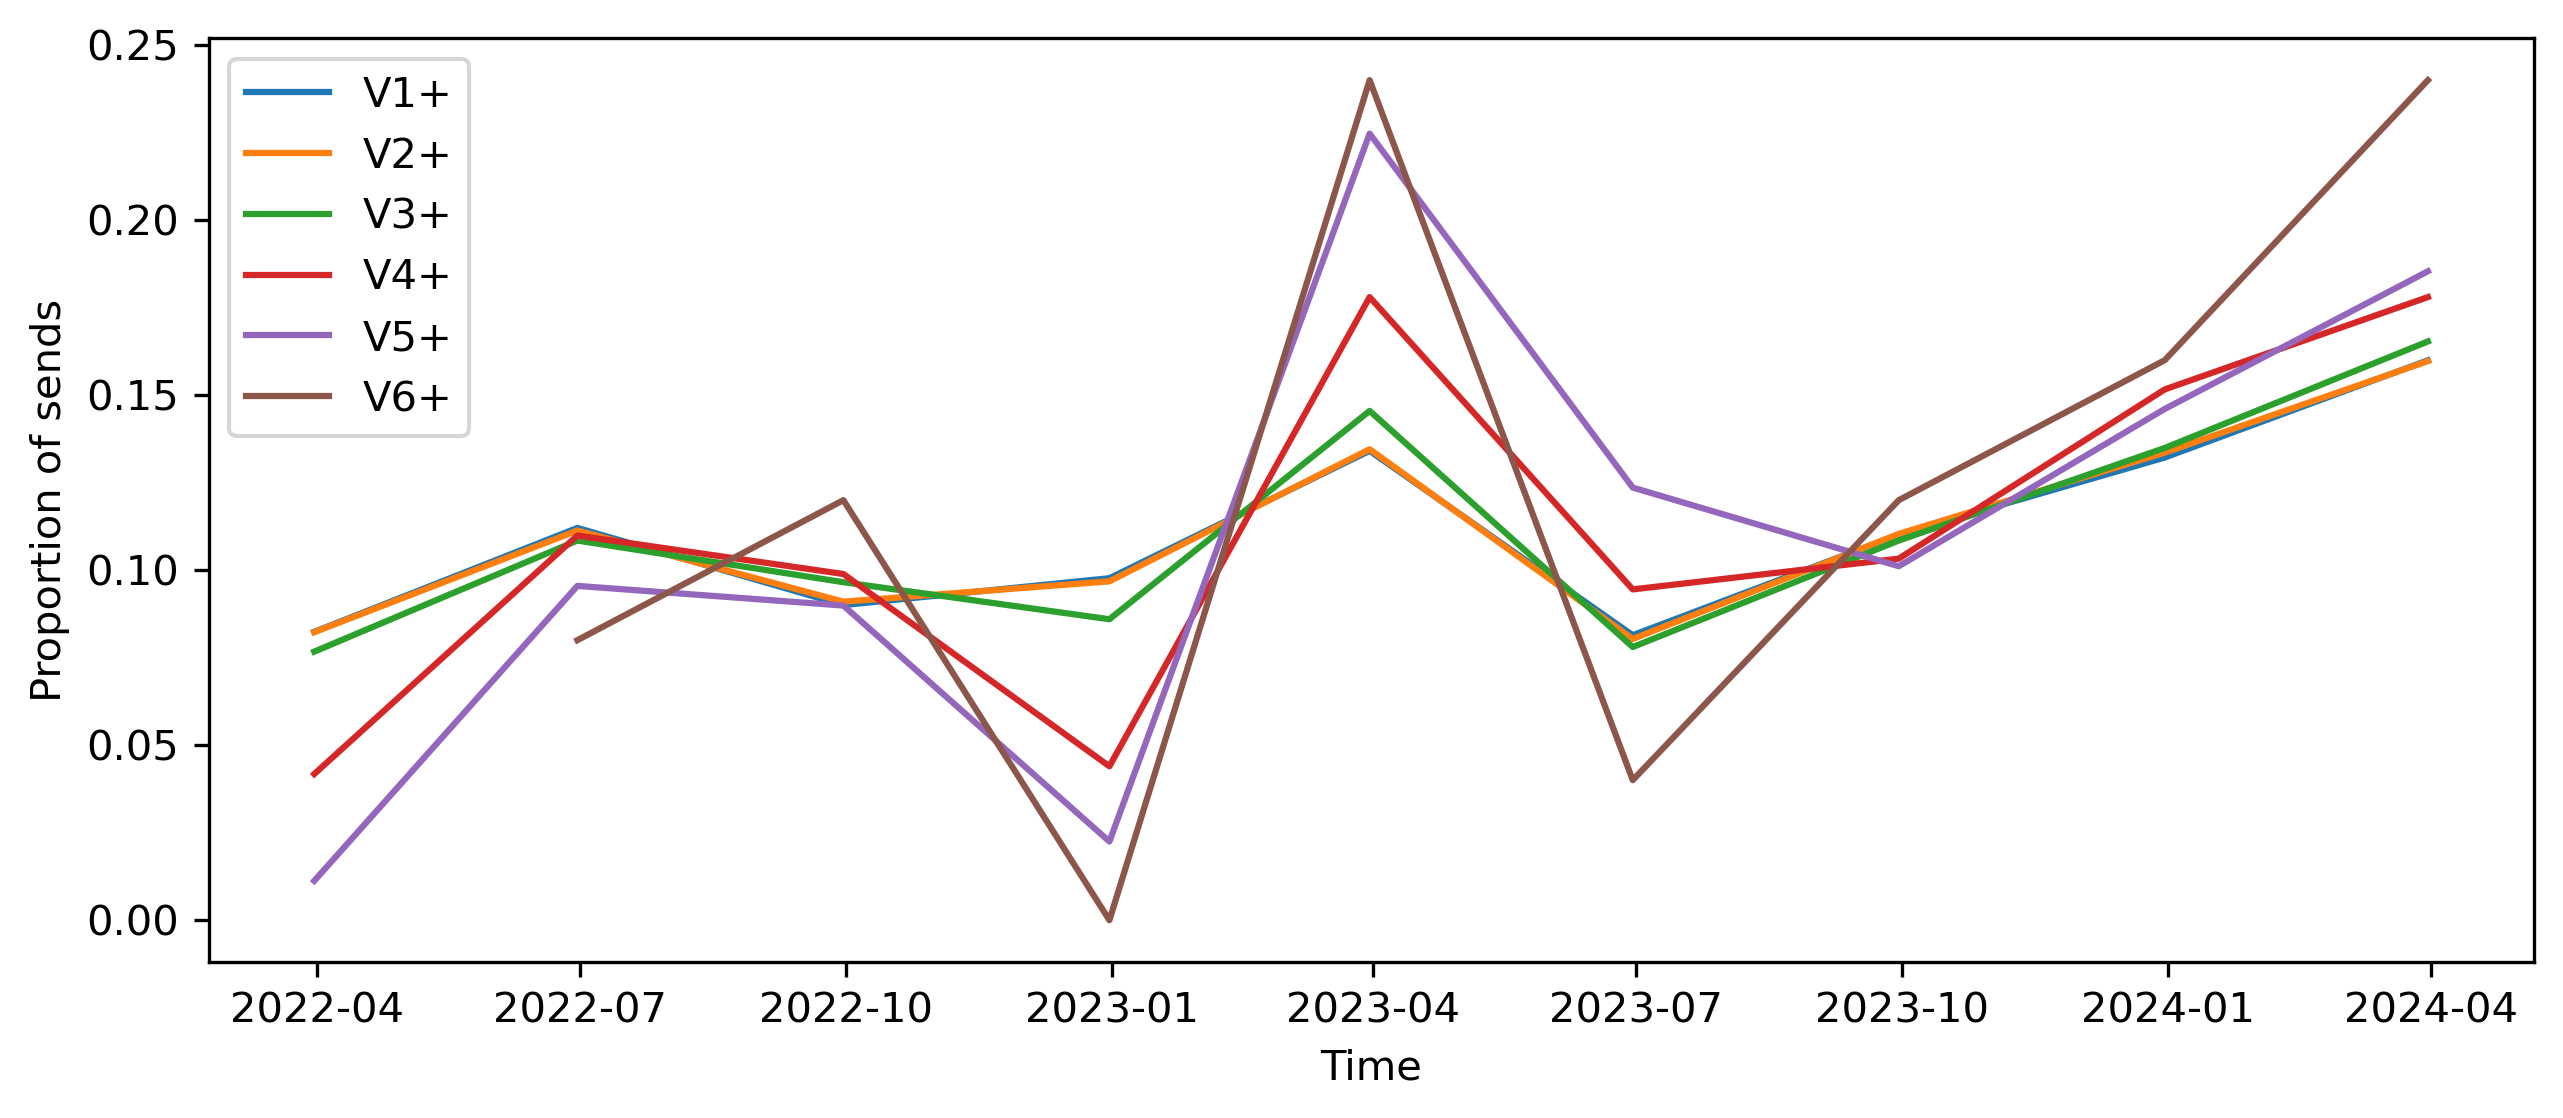

In [62]:
sends = boulders[boulders['Attempt'] == False]
sends['Time'] = pd.to_datetime(sends['Time'])  
sends.set_index('Time', inplace=True)


grade_scale = {'VB': 1, 'V1': 2, 'V2': 3, 'V3': 4, 'V4': 5, 'V5': 6}
sends['NumericLevel'] = sends['Level'].map(grade_scale)
legend_labels = []
lines = [] 

plt.figure(figsize=(10,4),dpi=300)
ax = plt.gca()  

for grade, numeric_value in grade_scale.items():
    if grade != 'V6':
        grade_counts = count_grades_or_higher(sends, numeric_value)
        total_climbs = grade_counts.sum()  
        normalized_counts = grade_counts / total_climbs
        line = ax.plot(normalized_counts.index, normalized_counts.values)[0]  # Get the line object
        lines.append(line)  # Collect lines for legend
        legend_labels.append(f'V{grade_scale[grade]}+')


plt.legend(handles=lines, labels=legend_labels)

plt.xlabel('Time')
plt.ylabel('Proportion of sends')
plt.show()